In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv


In [2]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib
from nltk.tokenize import RegexpTokenizer
import nltk
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix 
from imblearn.combine import SMOTETomek

nltk.download('stopwords')


stop_words = set(stopwords.words("english"))
default_stemmer = PorterStemmer()
default_stopwords = stopwords.words('english')
default_tokenizer=RegexpTokenizer(r"\w+")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv("../input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
df.shape

(17880, 18)

In [5]:
df.columns
df_columns = df.columns.tolist()

In [6]:
dataTypeSeries = df.dtypes
print('Data type of each column of Dataframe :')
print(dataTypeSeries)

Data type of each column of Dataframe :
job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object


In [7]:
df[df_columns].isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [8]:
df = df.replace(np.nan, '', regex=True)

In [9]:
df["fraudulent"].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

4.8434% (Approx 5%) Fake job post.


In [10]:
df['text'] = df[['title', 'department','company_profile','description','requirements','benefits']].apply(lambda x: ' '.join(x), axis = 1) 

In [11]:
df.drop(['job_id', 'location','title','salary_range' ,'department','salary_range','company_profile','description','requirements','benefits'], axis=1, inplace=True)

In [12]:
df.columns
df_columns = df.columns.tolist()

In [13]:
from sklearn.preprocessing import LabelEncoder
label_columns = ['telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function']
lb_make = LabelEncoder()
for i in label_columns:
  df[i] = lb_make.fit_transform(df[i])

In [14]:
df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text
0,0,1,0,3,5,0,0,23,0,"Marketing Intern Marketing We're Food52, and w..."
1,0,1,0,2,7,0,76,8,0,Customer Service - Cloud Video Production Succ...
2,0,1,0,0,0,0,0,0,0,Commissioning Machinery Assistant (CMA) Valor...
3,0,1,0,2,6,2,23,32,0,Account Executive - Washington DC Sales Our pa...
4,0,1,1,2,6,2,52,17,0,Bill Review Manager SpotSource Solutions LLC ...


In [15]:
df_columns = df_columns[-1:] + df_columns[:-1]
df = df[df_columns]
df.head()

,text,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,"Marketing Intern Marketing We're Food52, and w...",0,1,0,3,5,0,0,23,0
1,Customer Service - Cloud Video Production Succ...,0,1,0,2,7,0,76,8,0
2,Commissioning Machinery Assistant (CMA) Valor...,0,1,0,0,0,0,0,0,0
3,Account Executive - Washington DC Sales Our pa...,0,1,0,2,6,2,23,32,0
4,Bill Review Manager SpotSource Solutions LLC ...,0,1,1,2,6,2,52,17,0


In [16]:
  def clean_text(text, ):
        if text is not None:
        #exclusions = ['RE:', 'Re:', 're:']
        #exclusions = '|'.join(exclusions)
                text = re.sub(r'[0-9]+','',text)
                text =  text.lower()
                text = re.sub('re:', '', text)
                text = re.sub('-', '', text)
                text = re.sub('_', '', text)
                text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
                text = re.sub(r'\S*@\S*\s?', '', text, flags=re.MULTILINE)
        # Remove text between square brackets
                text =re.sub('\[[^]]*\]', '', text)
        # removes punctuation
                text = re.sub(r'[^\w\s]','',text)
                text = re.sub(r'\n',' ',text)
                text = re.sub(r'[0-9]+','',text)
                #text = re.sub(r'[0-9]+','',text)
        # strip html 
                p = re.compile(r'<.*?>')
                text = re.sub(r"\'ve", " have ", text)
                text = re.sub(r"can't", "cannot ", text)
                text = re.sub(r"n't", " not ", text)
                text = re.sub(r"I'm", "I am", text)
                text = re.sub(r" m ", " am ", text)
                text = re.sub(r"\'re", " are ", text)
                text = re.sub(r"\'d", " would ", text)
                text = re.sub(r"\'ll", " will ", text)
        
                text = p.sub('', text)

        def tokenize_text(text,tokenizer=default_tokenizer):
            token = default_tokenizer.tokenize(text)
            return token
        
        def remove_stopwords(text, stop_words=default_stopwords):
            tokens = [w for w in tokenize_text(text) if w not in stop_words]
            return ' '.join(tokens)

        def stem_text(text, stemmer=default_stemmer):
            tokens = tokenize_text(text)
            return ' '.join([stemmer.stem(t) for t in tokens])

        text = stem_text(text) # stemming
        text = remove_stopwords(text) # remove stopwords
        #text.strip(' ') # strip whitespaces again?

        return text

In [17]:
df['text'] = df['text'].apply(clean_text)

In [18]:
df['text'].head()

0    market intern market food weve creat groundbre...
1    custom servic cloud video product success seco...
2    commiss machineri assist cma valor servic prov...
3    account execut washington dc sale passion impr...
4    bill review manag spotsourc solut llc global h...
Name: text, dtype: object

In [19]:
cv = TfidfVectorizer(max_features = 100)
x = cv.fit_transform(df['text'])
df1 = pd.DataFrame(x.toarray(), columns=cv.get_feature_names())
df.drop(["text"], axis=1, inplace=True)
main_df = pd.concat([df1,df], axis=1)

In [20]:
main_df.head()

,abil,account,also,amp,applic,base,benefit,best,build,busi,...,year,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0.000000,0.000000,0.116434,0.102818,0.000000,0.000000,0.000000,0.119893,0.000000,0.091077,...,0.000000,0,1,0,3,5,0,0,23,0
1,0.000000,0.041469,0.033522,0.059203,0.000000,0.061404,0.000000,0.000000,0.000000,0.104886,...,0.000000,0,1,0,2,7,0,76,8,0
2,0.000000,0.000000,0.000000,0.092825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0,1,0,0,0,0,0,0,0
3,0.039152,0.566401,0.000000,0.000000,0.000000,0.000000,0.089800,0.000000,0.118249,0.293025,...,0.058842,0,1,0,2,6,2,23,32,0
4,0.000000,0.109922,0.000000,0.000000,0.086042,0.000000,0.095852,0.182991,0.000000,0.069505,...,0.062808,0,1,1,2,6,2,52,17,0


In [21]:
Y = main_df.iloc[:,-1]
X = main_df.iloc[:,:-1]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
rfc = RandomForestClassifier(n_jobs=3,oob_score=True,n_estimators=100,criterion="entropy")
model=rfc.fit(X_train,y_train)

In [23]:
rfc.score(X_train,y_train)

1.0

In [24]:
rfc.score(X_test,y_test)

0.970917225950783

In [25]:
rfc_predict = rfc.predict(X_test)

In [26]:
print(classification_report(y_test, rfc_predict))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4247
           1       0.99      0.42      0.59       223

    accuracy                           0.97      4470
   macro avg       0.98      0.71      0.79      4470
weighted avg       0.97      0.97      0.97      4470



In [27]:
confusion_matrix(y_test, rfc_predict)

array([[4246,    1],
       [ 129,   94]])

# Creating balance data for good recall and precision


In [28]:
smk  = SMOTETomek(random_state=42)
X_res,Y_res= smk.fit_sample(X,Y)

In [29]:
X_res.shape,Y_res.shape

((34016, 108), (34016,))

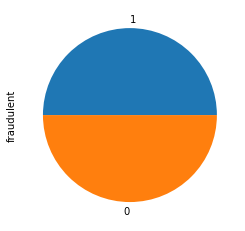

In [30]:
Y_res.value_counts().plot(kind="pie")

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_res,Y_res, test_size=0.25, random_state=42)
rfc = RandomForestClassifier(n_jobs=3,oob_score=True,n_estimators=100,criterion="entropy")
model=rfc.fit(X_train,y_train)

In [32]:
rfc.score(X_train,y_train)

1.0

In [33]:
rfc.score(X_test,y_test)

0.9935324553151458

In [34]:
rfc_predict = rfc.predict(X_test)

In [35]:
print(classification_report(y_test, rfc_predict))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4241
           1       0.99      0.99      0.99      4263

    accuracy                           0.99      8504
   macro avg       0.99      0.99      0.99      8504
weighted avg       0.99      0.99      0.99      8504



In [36]:
confusion_matrix(y_test, rfc_predict)

array([[4213,   28],
       [  27, 4236]])